### Numerical visualization in latent space

- Process warning

In [22]:
import warnings
warnings.filterwarnings('ignore')

- Loading modules

In [23]:
import pandas as pd
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
from Bio import SeqIO
from transformers import AutoModel, AutoTokenizer
import numpy as np
import torch
from tqdm import tqdm

- Auxiliar functions

In [24]:
def embedding_batch(tokenizer, device, model, batch, max_length=1024):
    inputs = tokenizer(
        batch,
        return_tensors="pt",
        truncation=True,
        padding=True,
        add_special_tokens=False,
        max_length=max_length,
    ).to(device)

    inputs = {key: value.to(device) for key, value in inputs.items()}

    with torch.no_grad():
        all_hiden_layers = model(**inputs, output_hidden_states=False)

    del inputs

    return all_hiden_layers.last_hidden_state

- Reading raw fasta and generate a raw dataframe

In [25]:
processed_sequences = []

for record in SeqIO.parse("tmp.fasta", "fasta"):

    if ("Alpha" in record.description or "Beta" in record.description):
        subtype = record.description.split("|")[-1]
    elif "Studied" in record.description:
        subtype = "A. purpuratus"
    else:
        subtype = "Non specificied"

    processed_sequences.append({
        "Organism" : record.description.replace("-", " ").split("]")[1].split("|")[0].split("Frame")[0],
        "Accession" : record.description.split("]")[0].replace("[", ""),
        "Subtype" : subtype,
        "Sequence" : str(record.seq)
    })

raw_df = pd.DataFrame(processed_sequences)
raw_df.head(5)

,Organism,Accession,Subtype,Sequence
0,A. irradians,XP_069111413,Alpha,MDKLKKERIRKVNPVSQKVKLFRASEPLLSVFMWGINHTINGLNHV...
1,P. maximus,XP_033762842,Alpha,MDKLKKERIRKVNPVSQKVKLFRASEPLLSVFMWGINHTINGLNHV...
2,Y. balloti,XP_060083998,Alpha,MDKLKKERIRKVNPVSQKVKLFRASEPLLSVFMWGINHTINGLNHV...
3,M. yessoensis,XP_021377781,Beta,MDKLKKERIRKVNPVSQKVKLFRASEPLLSVFMWGINHTINGLNHV...
4,R. philippinarum,XP_060589942,Alpha,MASVQTVPKQKVLKVKAVYQKRKLFRANEPLLSVFMWGINHTVSEL...


In [26]:
raw_df["Subtype"].value_counts()

Alpha              28
Beta               10
Non specificied     7
A. purpuratus       1
Name: Subtype, dtype: int64

In [27]:
raw_df.columns

Index(['Organism', 'Accession', 'Subtype', 'Sequence'], dtype='object')

- Starting embedding extraction: Preparing pre-trained model

In [28]:
name_model = "facebook/esm2_t6_8M_UR50D"
name_device = "cuda"

device = torch.device(name_device)
tokenizer = AutoTokenizer.from_pretrained(name_model, do_lower_case=False)
model = AutoModel.from_pretrained(name_model).to(device)
model.eval()

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EsmModel(
  (embeddings): EsmEmbeddings(
    (word_embeddings): Embedding(33, 320, padding_idx=1)
    (dropout): Dropout(p=0.0, inplace=False)
    (position_embeddings): Embedding(1026, 320, padding_idx=1)
  )
  (encoder): EsmEncoder(
    (layer): ModuleList(
      (0-5): 6 x EsmLayer(
        (attention): EsmAttention(
          (self): EsmSelfAttention(
            (query): Linear(in_features=320, out_features=320, bias=True)
            (key): Linear(in_features=320, out_features=320, bias=True)
            (value): Linear(in_features=320, out_features=320, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (rotary_embeddings): RotaryEmbedding()
          )
          (output): EsmSelfOutput(
            (dense): Linear(in_features=320, out_features=320, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (LayerNorm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
        )
        (intermediate): EsmIntermediate(
    

- Embedding extraction

In [29]:
batch_size=10

sequences = raw_df["Sequence"].tolist()

layer_embeddings = []

for i in tqdm(range(0, len(sequences), batch_size), desc="[+] Embedding", unit="batch"):
    batch = sequences[i : i + batch_size]

    last_hidden_layer = embedding_batch(tokenizer=tokenizer, device=device, model=model, batch=batch)

    batch_embedding = last_hidden_layer.mean(dim=1).cpu().numpy()
    layer_embeddings.append(batch_embedding)

layer_embeddings = np.concatenate(layer_embeddings, axis=0)

header = [f"p_{i + 1}" for i in range(layer_embeddings.shape[1])]

df_embedding = pd.DataFrame(data=layer_embeddings, columns=header)

for column in ['Organism', 'Accession', 'Subtype']:
    df_embedding[column] = raw_df[column].values

df_embedding.head(5)

[+] Embedding: 100%|██████████| 5/5 [00:00<00:00, 17.82batch/s]


,p_1,p_2,p_3,p_4,p_5,p_6,p_7,p_8,p_9,p_10,...,p_314,p_315,p_316,p_317,p_318,p_319,p_320,Organism,Accession,Subtype
0,0.011214,-0.019663,0.107679,0.131824,0.083376,-0.034295,-0.026730,-0.125509,-0.149442,-0.170146,...,0.124073,0.106996,-0.080499,-0.047241,0.164060,-0.021175,0.028820,A. irradians,XP_069111413,Alpha
1,0.014028,-0.015263,0.093516,0.144540,0.104989,-0.026181,-0.012108,-0.125137,-0.139674,-0.172551,...,0.134798,0.127963,-0.076750,-0.046026,0.153913,-0.024680,0.021997,P. maximus,XP_033762842,Alpha
2,0.012982,-0.027826,0.094994,0.138186,0.092075,-0.039200,-0.031184,-0.129234,-0.141030,-0.177885,...,0.131012,0.123976,-0.070518,-0.040269,0.141144,-0.022393,0.036758,Y. balloti,XP_060083998,Alpha
3,-0.011086,-0.018023,0.091648,0.139869,0.131932,-0.019015,-0.014911,-0.121987,-0.121678,-0.173311,...,0.142700,0.126329,-0.084361,-0.034195,0.164271,-0.035118,0.019891,M. yessoensis,XP_021377781,Beta
4,0.023605,-0.052796,0.069550,0.137392,0.097633,-0.080081,-0.053613,-0.143139,-0.084147,-0.212017,...,0.116353,0.145644,-0.074341,-0.050943,0.120973,-0.034928,0.009496,R. philippinarum,XP_060589942,Alpha


- Embedding visualization

In [30]:
tsne_instance = TSNE(n_components=2, random_state=42)
data_tsne = tsne_instance.fit_transform(X=df_embedding.drop(columns=['Organism', 'Accession', 'Subtype']).values)

df_tsne = pd.DataFrame(data=data_tsne, columns=["t-SNE 1", "t-SNE 2"])
df_tsne["Subtype"] = df_embedding["Subtype"].values
df_tsne.head(5)

,t-SNE 1,t-SNE 2,Subtype
0,-0.680058,13.596807,Alpha
1,-0.759288,13.622346,Alpha
2,-0.547444,13.645936,Alpha
3,-0.783886,13.625185,Beta
4,0.260829,13.645704,Alpha


<Axes: xlabel='t-SNE 1', ylabel='t-SNE 2'>

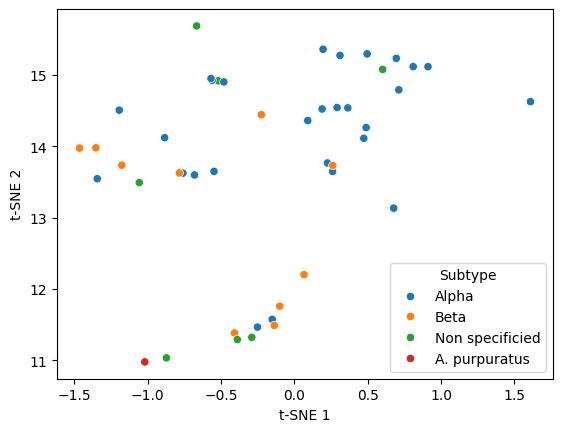

In [31]:
sns.scatterplot(data=df_tsne, x="t-SNE 1", y="t-SNE 2", hue="Subtype")